## application 데이터 세트에 다양한 feature engineering 수행

- application_train(test) 주요 feature값들의 분포도 등의 EDA 수행
- application_train(test) 주요 feature값들의 추가적인 가공을 통한 feature engineering 수행

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc, os, sys
import random

from sklearn.model_selection import KFold, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', 30)

In [4]:
app_train = pd.read_csv('../rawdata/application_train.csv')
app_test = pd.read_csv('../rawdata/application_test.csv')

In [8]:
app_train.isnull().sum().sort_values(ascending=False)

COMMONAREA_MEDI                 214865
COMMONAREA_AVG                  214865
COMMONAREA_MODE                 214865
NONLIVINGAPARTMENTS_MODE        213514
NONLIVINGAPARTMENTS_MEDI        213514
NONLIVINGAPARTMENTS_AVG         213514
FONDKAPREMONT_MODE              210295
LIVINGAPARTMENTS_MEDI           210199
LIVINGAPARTMENTS_MODE           210199
LIVINGAPARTMENTS_AVG            210199
FLOORSMIN_MEDI                  208642
FLOORSMIN_MODE                  208642
FLOORSMIN_AVG                   208642
YEARS_BUILD_MEDI                204488
YEARS_BUILD_AVG                 204488
YEARS_BUILD_MODE                204488
OWN_CAR_AGE                     202929
LANDAREA_MODE                   182590
LANDAREA_AVG                    182590
LANDAREA_MEDI                   182590
BASEMENTAREA_MEDI               179943
BASEMENTAREA_AVG                179943
BASEMENTAREA_MODE               179943
EXT_SOURCE_1                    173378
NONLIVINGAREA_MEDI              169682
NONLIVINGAREA_AVG        

In [9]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [10]:
app_train.info()

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


### 연속형 숫자 feature들에 대해 TARGET값이 각각 0과 1일때 Histogram시각화
- violinplot과 distplot으로 숫자형 feature들에 대해 TARGET값 별 분포도 비교 시각화

In [11]:
num_columns = app_train.dtypes[app_train.dtypes != 'object']
print(num_columns)

SK_ID_CURR                        int64
TARGET                            int64
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                        int64
FLAG_EMP_PHONE                    int64
FLAG_WORK_PHONE                   int64
FLAG_CONT_MOBILE                  int64
FLAG_PHONE                        int64
FLAG_EMAIL                        int64
CNT_FAM_MEMBERS                 float64
REGION_RATING_CLIENT              int64
REGION_RATING_CLIENT_W_CITY       int64
HOUR_APPR_PROCESS_START           int64
REG_REGION_NOT_LIVE_REGION        int64
REG_REGION_NOT_WORK_REGION        int64


In [15]:
def show_hist_by_target(df, columns):
    cond_1 = (df['TARGET'] == 1)
    cond_0 = (df['TARGET'] == 0)
    
    for column in columns:
        print('column name', column)
        fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2, squeeze=False)
        sns.violinplot(x='TARGET', y=column, data = df, ax=axes[0][0])
        sns.distplot(df[cond_1][column], label='1', color='red', ax=axes[0][1])
        sns.distplot(df[cond_0][column], label='0', color='blue', ax=axes[0][1])
        

column name AMT_INCOME_TOTAL
column name AMT_CREDIT
column name AMT_ANNUITY
column name AMT_GOODS_PRICE
column name DAYS_BIRTH
column name DAYS_EMPLOYED
column name DAYS_ID_PUBLISH
column name DAYS_REGISTRATION
column name DAYS_LAST_PHONE_CHANGE
column name CNT_FAM_MEMBERS
column name REGION_RATING_CLIENT
column name EXT_SOURCE_1
column name EXT_SOURCE_2
column name EXT_SOURCE_3
column name AMT_REQ_CREDIT_BUREAU_HOUR
column name AMT_REQ_CREDIT_BUREAU_DAY
column name AMT_REQ_CREDIT_BUREAU_WEEK
column name AMT_REQ_CREDIT_BUREAU_MON
column name AMT_REQ_CREDIT_BUREAU_QRT
column name AMT_REQ_CREDIT_BUREAU_YEAR


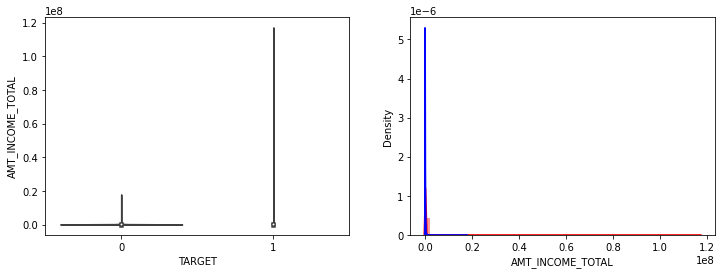

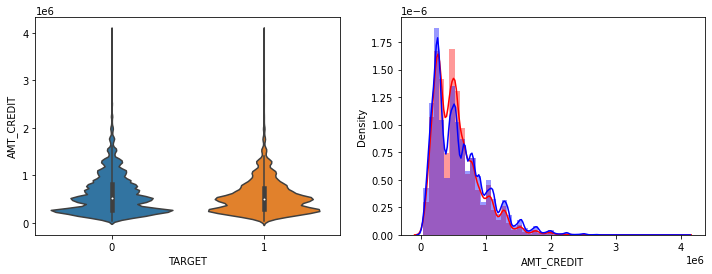

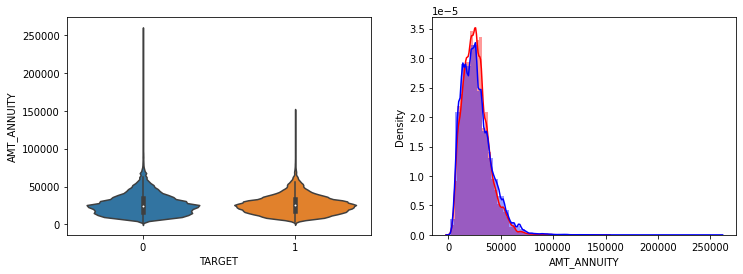

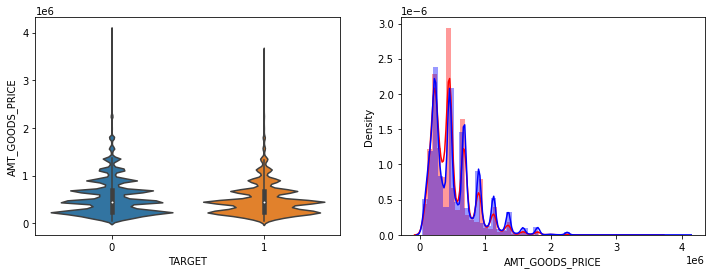

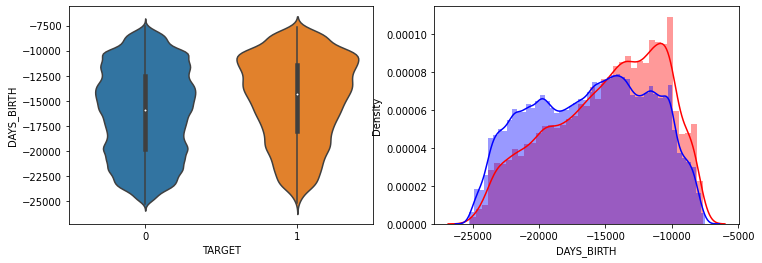

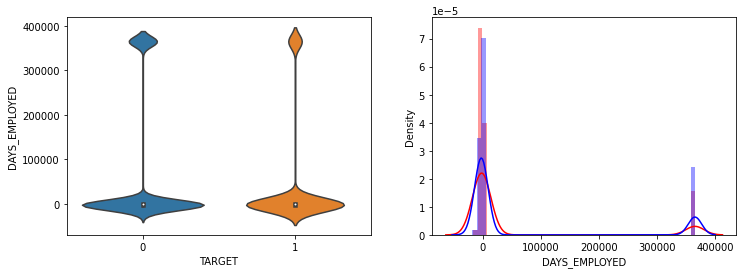

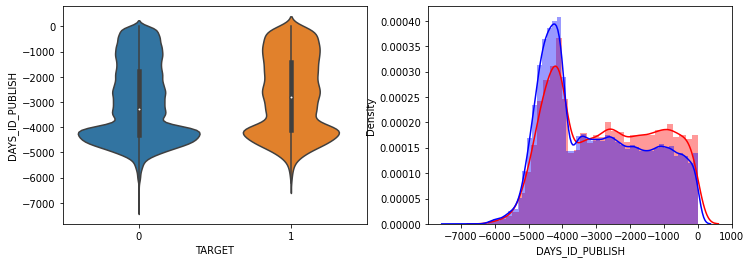

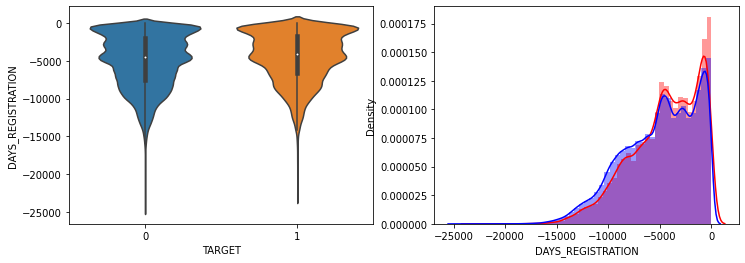

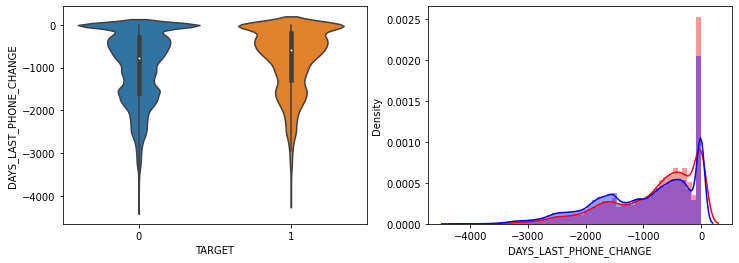

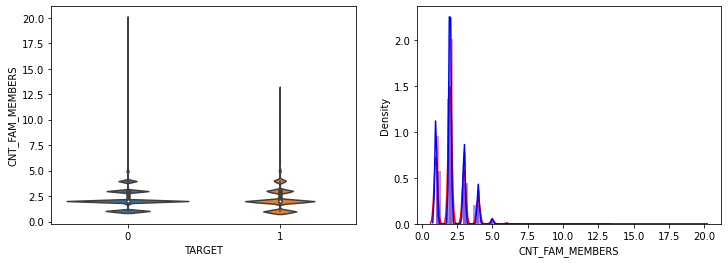

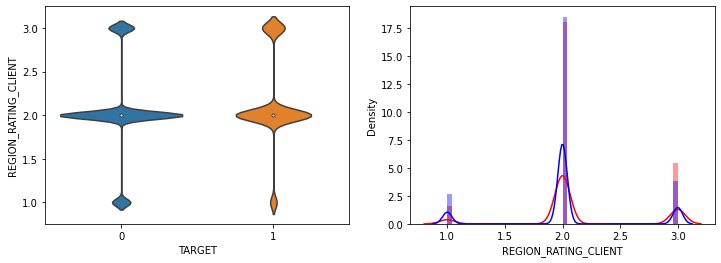

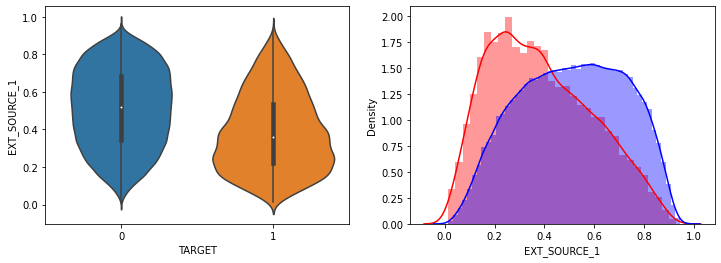

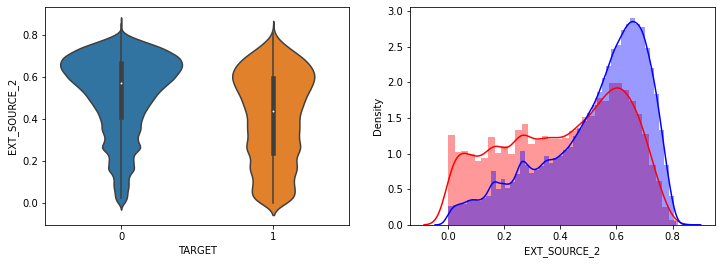

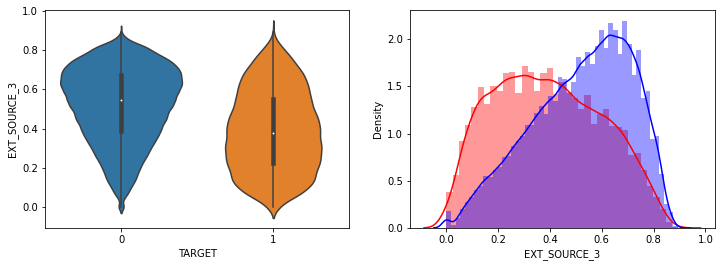

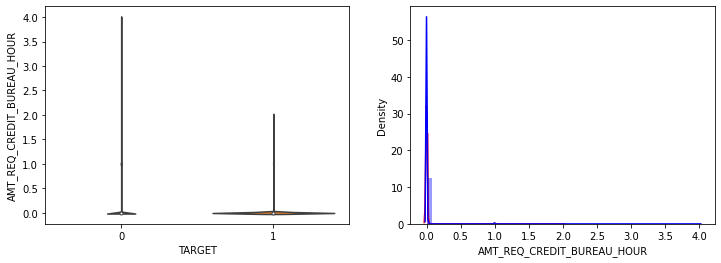

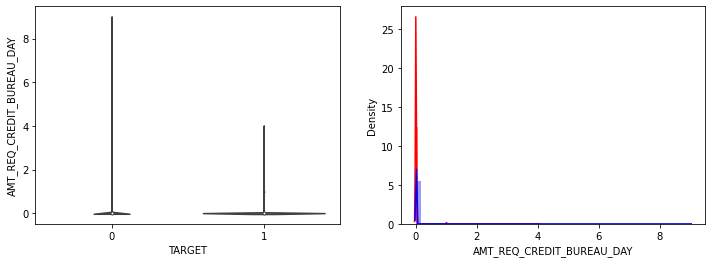

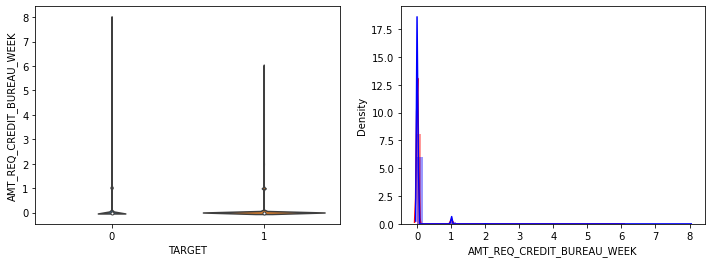

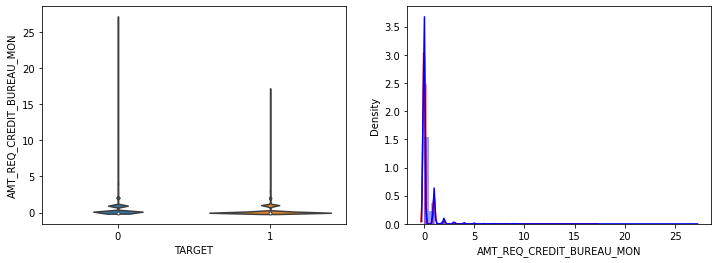

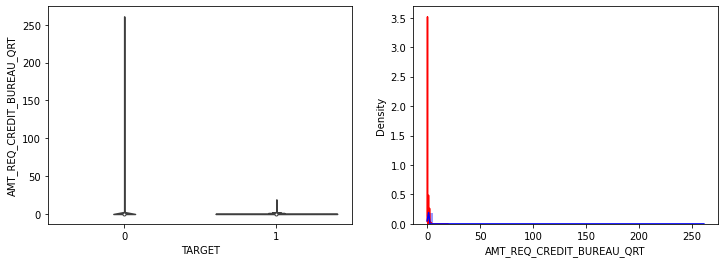

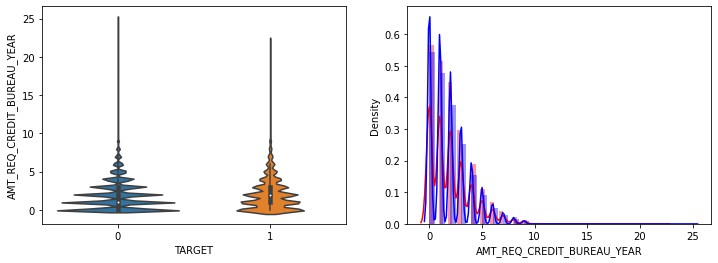

In [17]:
columns = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

show_hist_by_target(app_train, columns)

- AMT_INCOME_TOTAL, AMT_CREDIT은 크게 차이가 없음
- AMT_ANNUITY는 TARGET=1시 상대적으로 적은 숫자대의 값이 조금 많음
- AMT_GOOD_PRICE는 크게 차이가 없음
- DAYS_BIRTH는 TARGET=1시 적은 연령대의 숫자값이 상대적으로 많음
- DAYS_EMPLOYED는 TARGET=1시 작은 값들이 조금 더 많음
- DAYS_ID_PUBLISH, DAYS_REGISTRATION은 TARGET=1시 최근 값들이 조금 더 많음
- DAYS_LAST_PHONE_CHANGE는 큰 차이 없음
- CNT_FAM_MEMBERS는 차이가 없음. Outlier때문에 histogram에 차이가 있어 보임
- REGION_RATING_CLIENT는 큰 차이 없음
- EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 모두 조금씩 차이가 있음
- 나머지 컬럼 모두 큰 차이가 없음
- 전반적으로 연령대가 낮은(직장 경력이 적은) 소액 대출에서 상대적으로 연체 비중 높음


#### seaborn의 countplot()또는 catplot()을 이용하여 category feature을 TARGET 유형에 따라 Count 비교


In [23]:
object_columns = app_train.dtypes[app_train.dtypes == 'object'].index.tolist()
object_columns

[&#39;NAME_CONTRACT_TYPE&#39;,
 &#39;CODE_GENDER&#39;,
 &#39;FLAG_OWN_CAR&#39;,
 &#39;FLAG_OWN_REALTY&#39;,
 &#39;NAME_TYPE_SUITE&#39;,
 &#39;NAME_INCOME_TYPE&#39;,
 &#39;NAME_EDUCATION_TYPE&#39;,
 &#39;NAME_FAMILY_STATUS&#39;,
 &#39;NAME_HOUSING_TYPE&#39;,
 &#39;OCCUPATION_TYPE&#39;,
 &#39;WEEKDAY_APPR_PROCESS_START&#39;,
 &#39;ORGANIZATION_TYPE&#39;,
 &#39;FONDKAPREMONT_MODE&#39;,
 &#39;HOUSETYPE_MODE&#39;,
 &#39;WALLSMATERIAL_MODE&#39;,
 &#39;EMERGENCYSTATE_MODE&#39;]

column name NAME_CONTRACT_TYPE
column name CODE_GENDER
column name FLAG_OWN_CAR
column name FLAG_OWN_REALTY
column name NAME_TYPE_SUITE
column name NAME_INCOME_TYPE
column name NAME_EDUCATION_TYPE
column name NAME_FAMILY_STATUS
column name NAME_HOUSING_TYPE
column name OCCUPATION_TYPE
column name WEEKDAY_APPR_PROCESS_START
column name ORGANIZATION_TYPE
column name FONDKAPREMONT_MODE
column name HOUSETYPE_MODE
column name WALLSMATERIAL_MODE
column name EMERGENCYSTATE_MODE


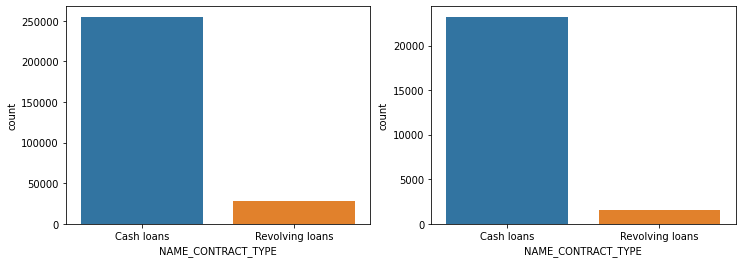

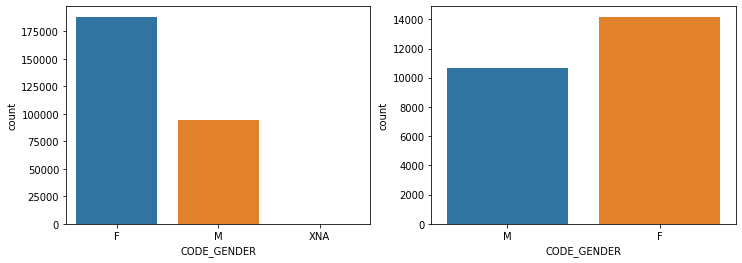

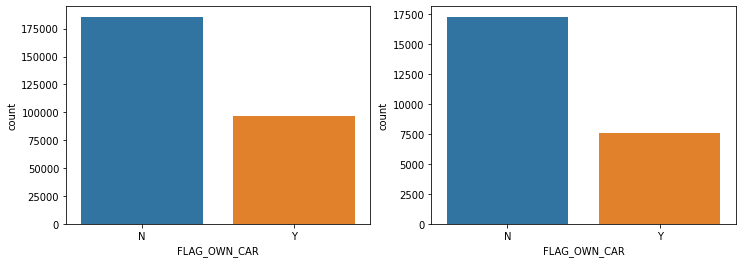

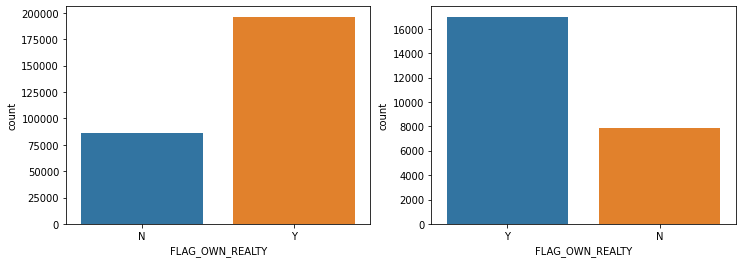

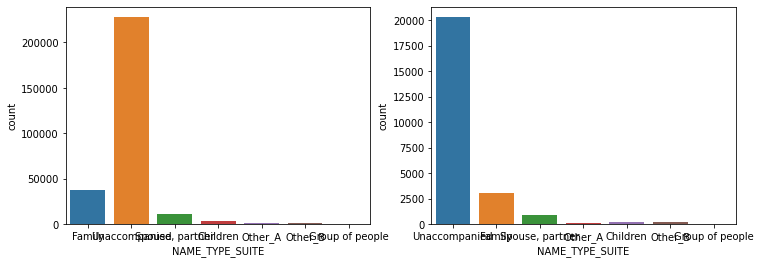

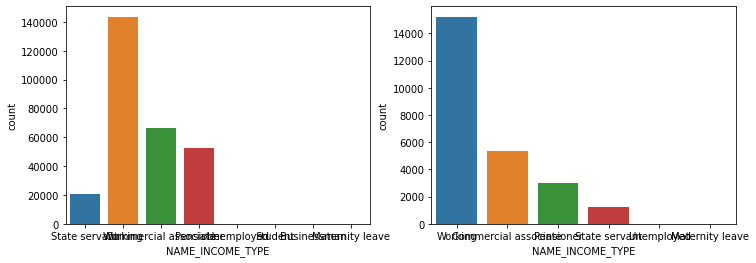

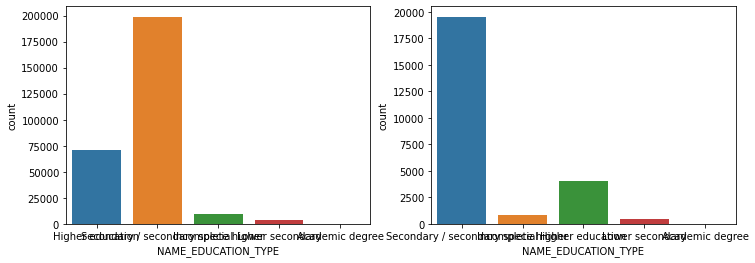

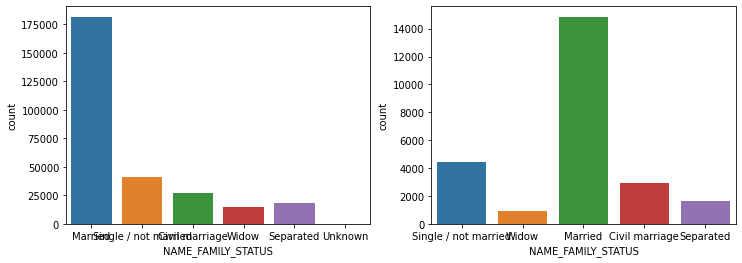

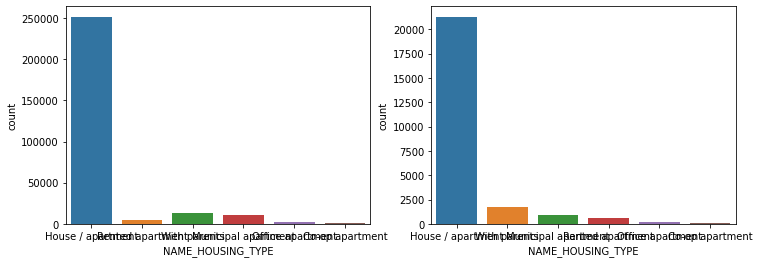

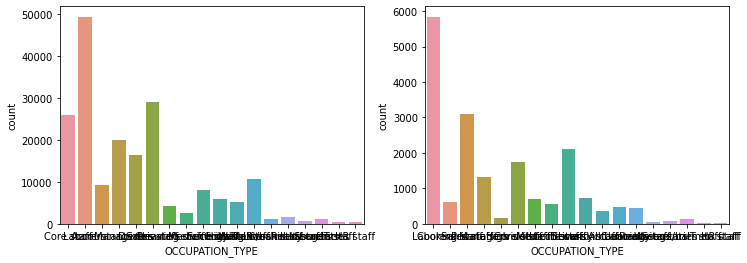

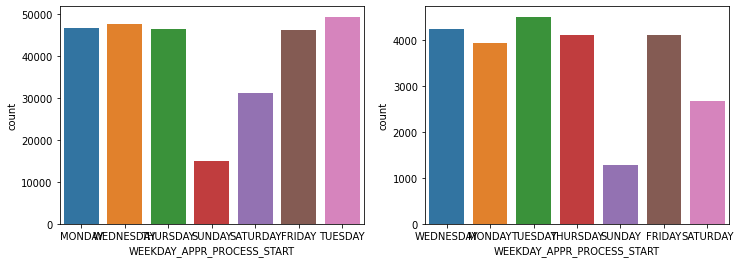

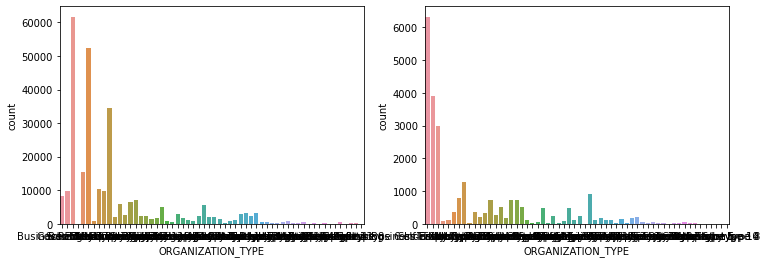

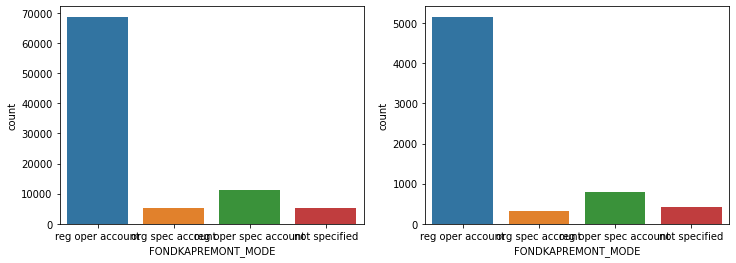

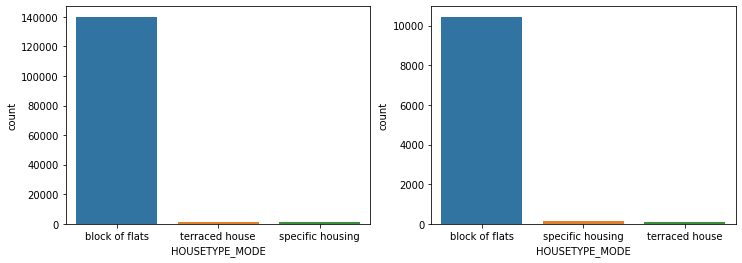

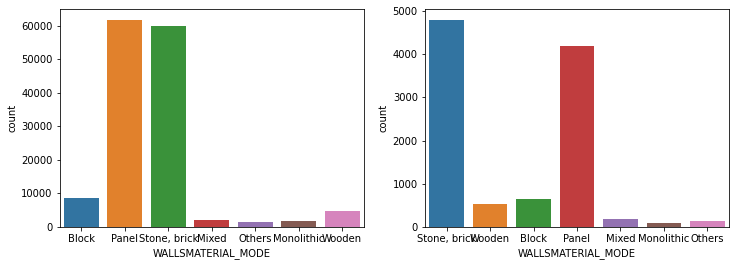

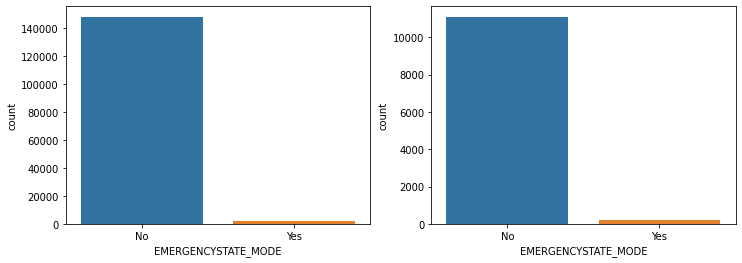

In [24]:
def show_count_by_target(df, columns):
    cond_1 = (df['TARGET'] == 1)
    cond_0 = (df['TARGET'] == 0)

    for column in columns:
        print('column name', column)
        fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2, squeeze=False)
        sns.countplot(df[cond_0][column], ax=axes[0][0])
        sns.countplot(df[cond_1][column], ax=axes[0][1])
        



show_count_by_target(app_train, object_columns)


&lt;seaborn.axisgrid.FacetGrid at 0x7f8fd05e54e0&gt;

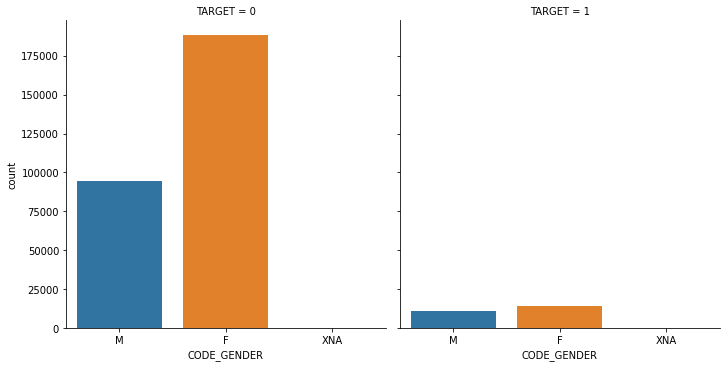

In [25]:
sns.catplot(x='CODE_GENDER', col='TARGET', data=app_train, kind='count')

column name:  NAME_CONTRACT_TYPE
column name:  CODE_GENDER
column name:  FLAG_OWN_CAR
column name:  FLAG_OWN_REALTY
column name:  NAME_TYPE_SUITE
column name:  NAME_INCOME_TYPE
column name:  NAME_EDUCATION_TYPE
column name:  NAME_FAMILY_STATUS
column name:  NAME_HOUSING_TYPE
column name:  OCCUPATION_TYPE
column name:  WEEKDAY_APPR_PROCESS_START
column name:  ORGANIZATION_TYPE
column name:  FONDKAPREMONT_MODE
column name:  HOUSETYPE_MODE
column name:  WALLSMATERIAL_MODE
column name:  EMERGENCYSTATE_MODE


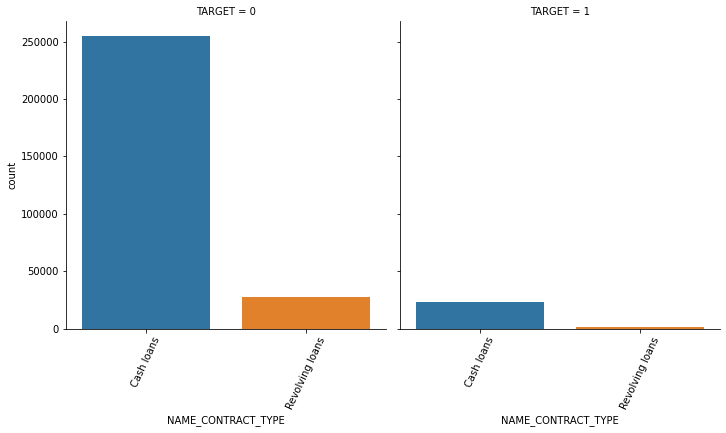

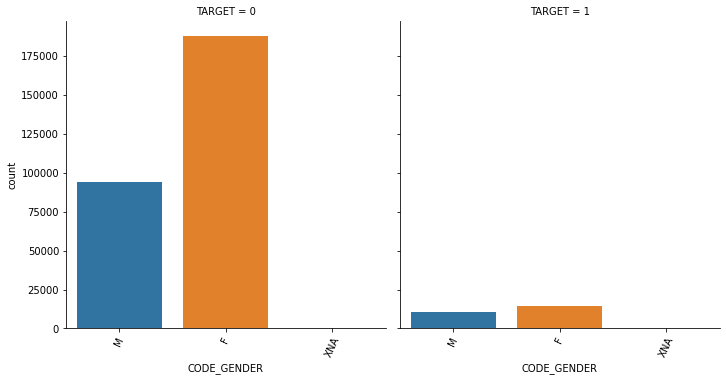

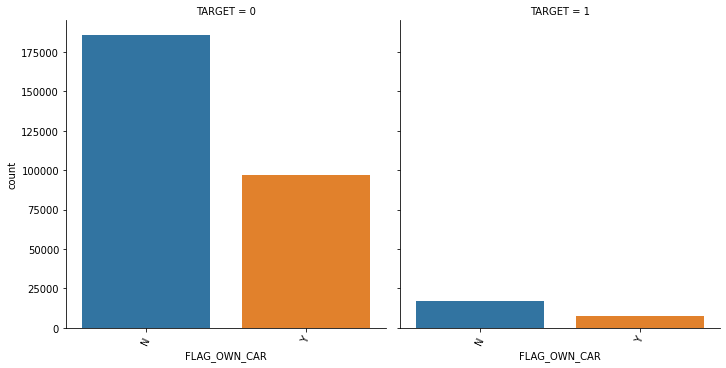

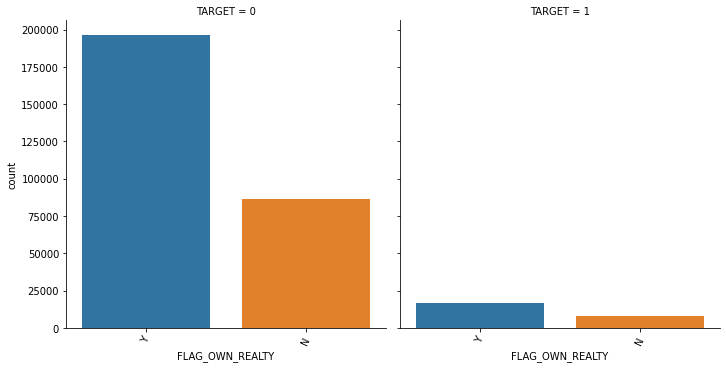

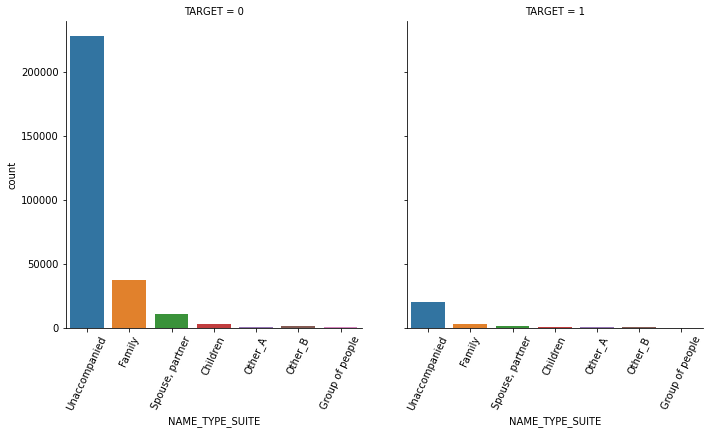

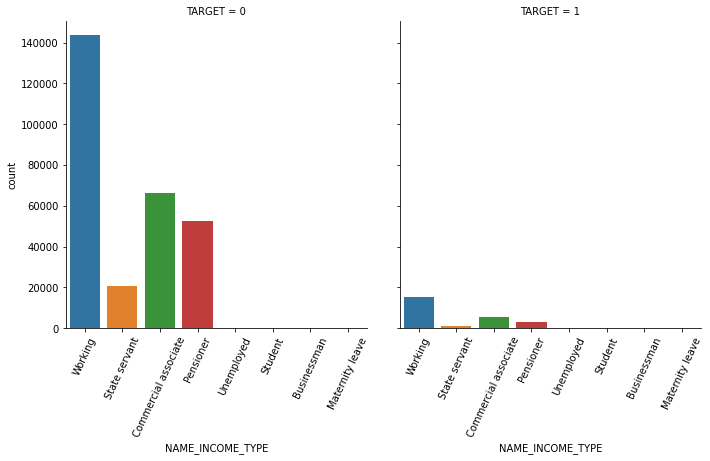

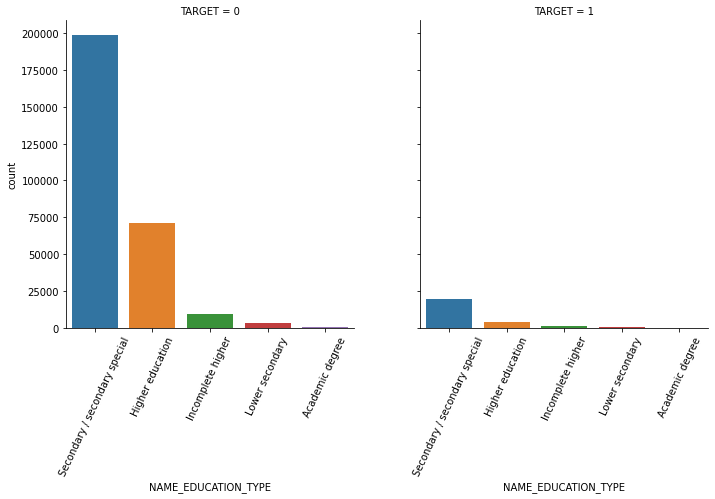

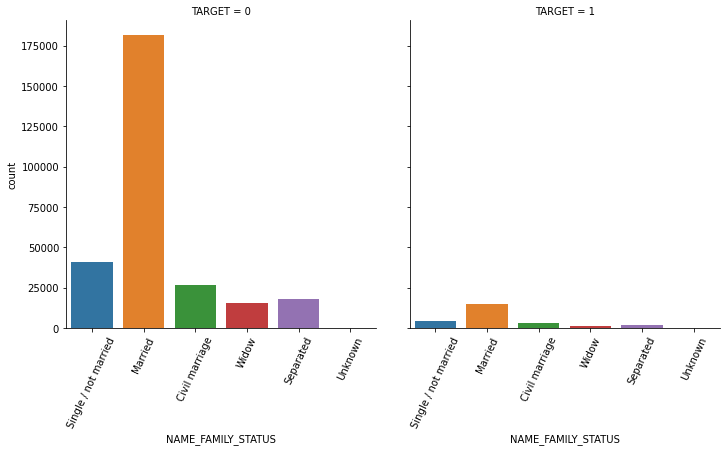

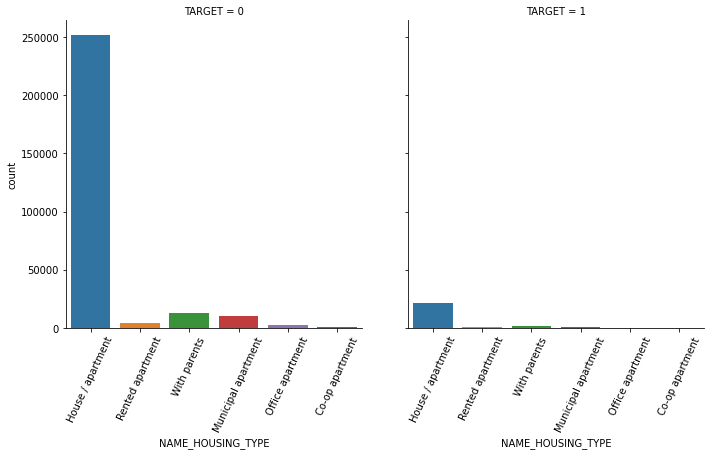

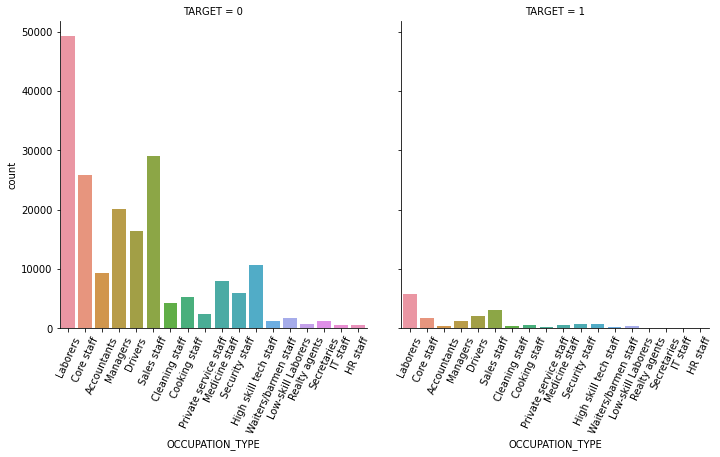

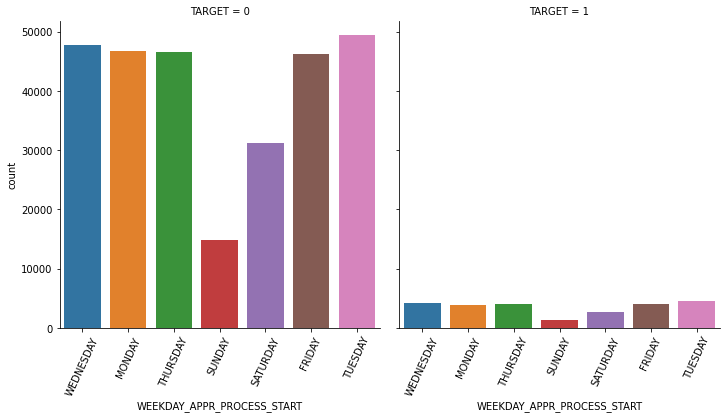

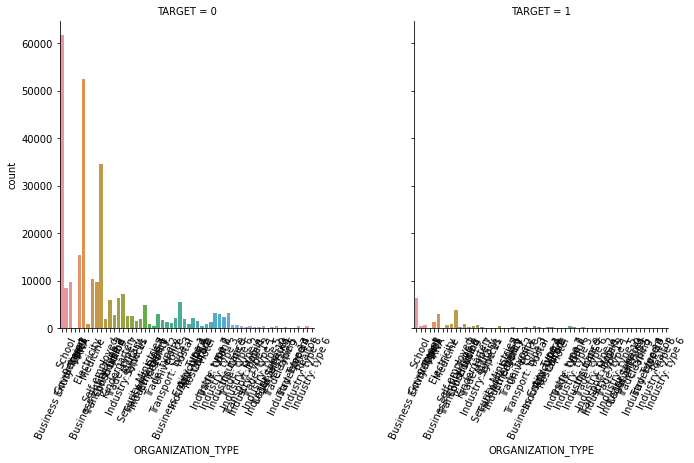

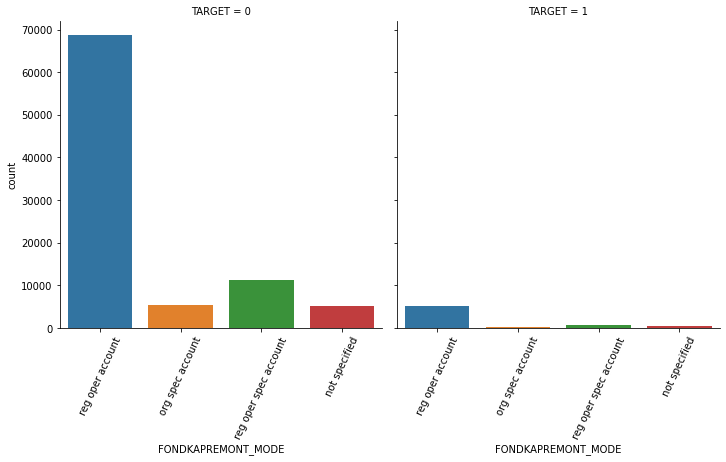

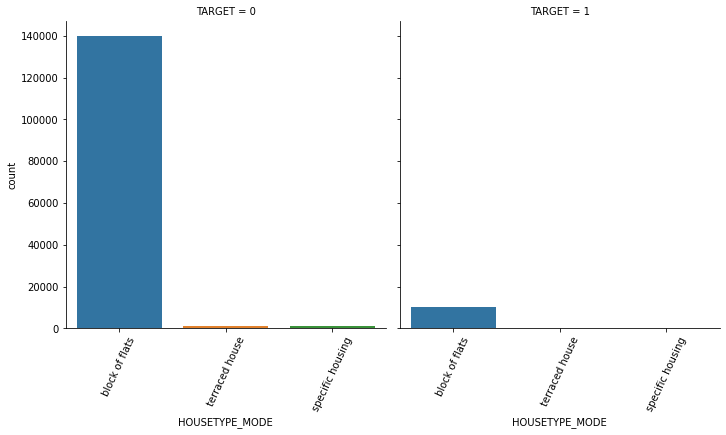

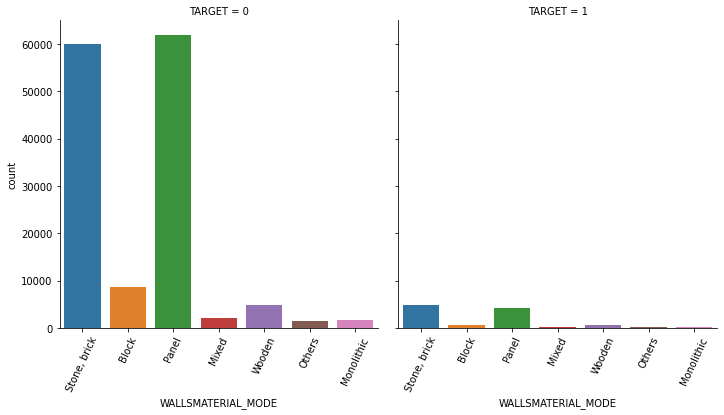

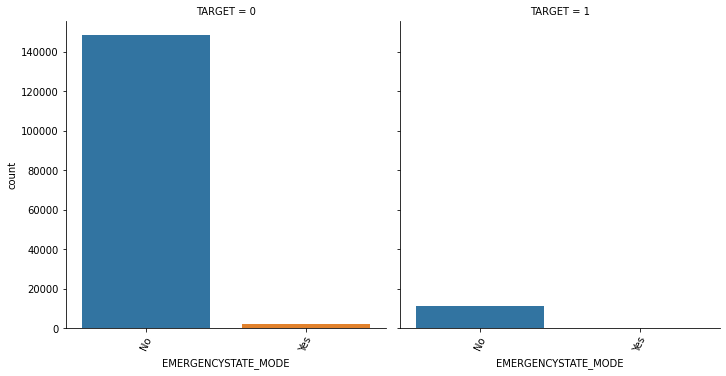

In [27]:
def show_category_by_target(df, columns):
    for column in columns:
        print('column name: ', column)
        chart = sns.catplot(x=column, col='TARGET', data = df, kind='count')
        chart.set_xticklabels(rotation=65)


show_category_by_target(app_train, object_columns)

#### 대출 횟수 대비 연체 비율이 남성이 여성보다 높음. 이를 value_counts()로 확인

In [28]:
cond_1 = (app_train['TARGET']==1)
cond_0 = (app_train['TARGET']==0)

In [39]:
app_train['CODE_GENDER'].value_counts() / app_train.shape[0]  * 100

F      65.834393
M      34.164306
XNA     0.001301
Name: CODE_GENDER, dtype: float64

In [41]:
app_train[cond_1]['CODE_GENDER'].value_counts() / app_train[cond_1].shape[0]  * 100

F    57.079557
M    42.920443
Name: CODE_GENDER, dtype: float64

In [42]:
app_train[cond_0]['CODE_GENDER'].value_counts() / app_train[cond_0].shape[0]  * 100

F      66.603228
M      33.395357
XNA     0.001415
Name: CODE_GENDER, dtype: float64

In [36]:
app_train[cond_1]['CODE_GENDER'].value_counts() / app_train[cond_0]['CODE_GENDER'].value_counts() * 100

F       7.526105
M      11.286598
XNA          NaN
Name: CODE_GENDER, dtype: float64

#### 주요 컬럼들의 target과의 상관도 분석 및 Heatmap 시각화

In [43]:
corr_columns = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE', 'AMT_INCOME_TOTAL', 'TARGET']

corr = app_train[corr_columns].corr()

&lt;matplotlib.axes._subplots.AxesSubplot at 0x7f8fd055a668&gt;

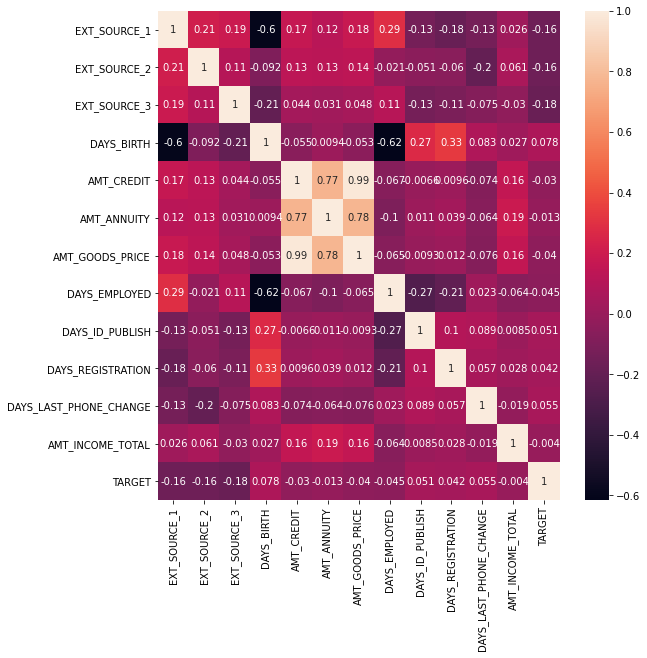

In [44]:
plt.figure(figsize=(9, 9))
sns.heatmap(corr, annot=True)

#### 이상치 데이터 확인 및 DAYS_EMPLOYED 이상치 값 변경

In [45]:
app_train['DAYS_EMPLOYED'].value_counts()

 365243    55374
-200         156
-224         152
-199         151
-230         151
           ...  
-11115         1
-11371         1
-11883         1
-13536         1
-8795          1
Name: DAYS_EMPLOYED, Length: 12574, dtype: int64

In [47]:
app_train['DAYS_EMPLOYED'] = app_train['DAYS_EMPLOYED'].replace(365243, np.nan)
app_train['DAYS_EMPLOYED'].value_counts(dropna=False)

 NaN        55374
-200.0        156
-224.0        152
-199.0        151
-230.0        151
            ...  
-8868.0         1
-13006.0        1
-10261.0        1
-14079.0        1
-9062.0         1
Name: DAYS_EMPLOYED, Length: 12574, dtype: int64

## 주요 Feature들에 대한 Feature Engineering 수행

### EXT_SOURCE 계열값 확인, EXT_SOURCE_X 피처들의 평균/최대/최소/표준편차 확인

In [48]:
app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].isnull().sum()

EXT_SOURCE_1    173378
EXT_SOURCE_2       660
EXT_SOURCE_3     60965
dtype: int64

In [49]:
app_train.shape

(307511, 122)

In [50]:
app_train['EXT_SOURCE_1'].value_counts(dropna=False)

NaN         173378
0.546426         5
0.598469         5
0.499002         5
0.605152         5
             ...  
0.381263         1
0.259241         1
0.116346         1
0.171978         1
0.844540         1
Name: EXT_SOURCE_1, Length: 114585, dtype: int64

In [51]:
app_train['EXT_SOURCE_2'].value_counts(dropna=False)

0.285898    721
NaN         660
0.262258    417
0.265256    343
0.159679    322
           ... 
0.383020      1
0.786006      1
0.256132      1
0.297243      1
0.336367      1
Name: EXT_SOURCE_2, Length: 119832, dtype: int64

In [52]:
app_train['EXT_SOURCE_3'].value_counts(dropna=False)

NaN         60965
0.746300     1460
0.713631     1315
0.694093     1276
0.670652     1191
            ...  
0.887664        1
0.879506        1
0.020311        1
0.849170        1
0.014556        1
Name: EXT_SOURCE_3, Length: 815, dtype: int64

In [53]:
# EXT_SOURCE_X 피처들의 평균/최대/최소/표준편차 확인
print('### mean ###\n', app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean())
print('### max ###\n', app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].max())
print('### min ###\n', app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].min())
print('### std ###\n', app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std())


### mean ###
 EXT_SOURCE_1    0.502130
EXT_SOURCE_2    0.514393
EXT_SOURCE_3    0.510853
dtype: float64
### max ###
 EXT_SOURCE_1    0.962693
EXT_SOURCE_2    0.855000
EXT_SOURCE_3    0.896010
dtype: float64
### min ###
 EXT_SOURCE_1    1.456813e-02
EXT_SOURCE_2    8.173617e-08
EXT_SOURCE_3    5.272652e-04
dtype: float64
### std ###
 EXT_SOURCE_1    0.211062
EXT_SOURCE_2    0.191060
EXT_SOURCE_3    0.194844
dtype: float64


#### 데이터 가공 전 학습과 테스트용 데이터 세트 결합

In [54]:
apps = pd.concat([app_train, app_test])
print(apps.shape)

(356255, 122)


### EXT_SOURCE_X FEATURE 가공

- EXT_SOURCE_X 피처들을 결합하여 평균과 표준 편차를 신규 생성

In [55]:
apps.head()

AMT_ANNUITY  AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
0      24700.5    406597.5         351000.0          202500.0   
1      35698.5   1293502.5        1129500.0          270000.0   
2       6750.0    135000.0         135000.0           67500.0   
3      29686.5    312682.5         297000.0          135000.0   
4      21865.5    513000.0         513000.0          121500.0   

   AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        NaN                         NaN   
4                        0.0                         0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        NaN                        NaN   
4                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_YEAR  APARTMENTS_AVG  \
0                         0.0                         1.0          0.0247   
1                         0.0                         0.0          0.0959   
2                         0.0                         0.0             NaN   
3                         NaN                         NaN             NaN   
4                         0.0                         0.0             NaN   

   APARTMENTS_MEDI  APARTMENTS_MODE  BASEMENTAREA_AVG  BASEMENTAREA_MEDI  \
0           0.0250           0.0252            0.0369             0.0369   
1           0.0968           0.0924            0.0529             0.0529   
2              NaN              NaN               NaN                NaN   
3              NaN              NaN               NaN                NaN   
4              NaN              NaN               NaN                NaN   

   BASEMENTAREA_MODE  CNT_CHILDREN  CNT_FAM_MEMBERS CODE_GENDER  \
0             0.0383             0              1.0           M   
1             0.0538             0              2.0           F   
2                NaN             0              1.0           M   
3                NaN             0              2.0           F   
4                NaN             0              1.0           M   

   COMMONAREA_AVG  COMMONAREA_MEDI  COMMONAREA_MODE  DAYS_BIRTH  \
0          0.0143           0.0144           0.0144       -9461   
1          0.0605           0.0608           0.0497      -16765   
2             NaN              NaN              NaN      -19046   
3             NaN              NaN              NaN      -19005   
4             NaN              NaN              NaN      -19932   

   DAYS_EMPLOYED  DAYS_ID_PUBLISH  DAYS_LAST_PHONE_CHANGE  DAYS_REGISTRATION  \
0         -637.0            -2120                 -1134.0            -3648.0   
1        -1188.0             -291                  -828.0            -1186.0   
2         -225.0            -2531                  -815.0            -4260.0   
3        -3039.0            -2437                  -617.0            -9833.0   
4        -3038.0            -3458                 -1106.0            -4311.0   

   DEF_30_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  ELEVATORS_AVG  \
0                       2.0                       2.0           0.00   
1                       0.0                       0.0           0.08   
2                       0.0                       0.0            NaN   
3                       0.0                       0.0            NaN   
4                       0.0                       0.0            NaN   

   ELEVATORS_MEDI  ELEVATORS_MODE EMERGENCYSTATE_MODE  ENTRANCES_AVG  \
0            0.00          0.0000                  No         0.0690   
1            0.08          0.0806                  No         0.0345   
2             NaN             NaN       

In [58]:
apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)

In [61]:
apps.iloc[:, -2:].head(10)

APPS_EXT_SOURCE_MEAN  APPS_EXT_SOURCE_STD
0              0.161787             0.092026
1              0.466757             0.219895
2              0.642739             0.122792
3              0.650442                  NaN
4              0.322738                  NaN
5              0.487726             0.188799
6              0.663607             0.150717
7              0.627467             0.122771
8              0.514935             0.280096
9              0.746644                  NaN

In [62]:
apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APPS_EXT_SOURCE_STD']]

EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APPS_EXT_SOURCE_STD
0          0.083037      0.262949      0.139376             0.092026
1          0.311267      0.622246           NaN             0.219895
2               NaN      0.555912      0.729567             0.122792
3               NaN      0.650442           NaN                  NaN
4               NaN      0.322738           NaN                  NaN
...             ...           ...           ...                  ...
48739           NaN      0.648575      0.643026             0.003924
48740           NaN      0.684596           NaN                  NaN
48741      0.733503      0.632770      0.283712             0.236044
48742      0.373090      0.445701      0.595456             0.113391
48743           NaN      0.456541      0.272134             0.130395

[356255 rows x 4 columns]

In [63]:
apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())

#### AMT_CREDIT 비율로 Feature 가공

In [64]:
apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY'] / apps['AMT_CREDIT']
apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE'] / apps['AMT_CREDIT']
apps['APPS_CREDIT_GOODS_DIFF'] = apps['AMT_CREDIT'] - apps['AMT_GOODS_PRICE']


#### AMT_INCOME_TOTAL 비율로 Feature 가공

In [65]:
# AMT_INCOME_TOTAL 비율로 대출 금액 관련 피처 가공
apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY'] / apps['AMT_INCOME_TOTAL']
apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT'] / apps['AMT_INCOME_TOTAL']
apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE'] / apps['AMT_INCOME_TOTAL']

# 가족 수를 고려한 가처분 소득 피처 가공
apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL'] / apps['CNT_FAM_MEMBERS']

#### DAYS_BIRTH, DAYS_EMPLOYED 비율로 Feature 가공

In [66]:
apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED'] / apps['DAYS_BIRTH']
apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL'] / apps['DAYS_EMPLOYED']
apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL'] / apps['DAYS_BIRTH']
apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']

#### 레이블 인코딩, NULL값은 LightGBM 내부에서 처리하도록 특별한 변경하지 않음

In [67]:
object_columns = apps.dtypes[apps.dtypes=='object'].index.tolist()
object_columns

[&#39;CODE_GENDER&#39;,
 &#39;EMERGENCYSTATE_MODE&#39;,
 &#39;FLAG_OWN_CAR&#39;,
 &#39;FLAG_OWN_REALTY&#39;,
 &#39;FONDKAPREMONT_MODE&#39;,
 &#39;HOUSETYPE_MODE&#39;,
 &#39;NAME_CONTRACT_TYPE&#39;,
 &#39;NAME_EDUCATION_TYPE&#39;,
 &#39;NAME_FAMILY_STATUS&#39;,
 &#39;NAME_HOUSING_TYPE&#39;,
 &#39;NAME_INCOME_TYPE&#39;,
 &#39;NAME_TYPE_SUITE&#39;,
 &#39;OCCUPATION_TYPE&#39;,
 &#39;ORGANIZATION_TYPE&#39;,
 &#39;WALLSMATERIAL_MODE&#39;,
 &#39;WEEKDAY_APPR_PROCESS_START&#39;]

In [68]:
for column in object_columns:
    apps[column] = pd.factorize(apps[column])[0]

#### 학습 데이터와 테스트 데이터 다시 분리

In [70]:
apps_train = apps[~apps['TARGET'].isnull()]
apps_test = apps[apps['TARGET'].isnull()]

apps.shape, apps_train.shape, apps_test.shape

((356255, 136), (307511, 136), (48744, 136))

In [77]:
from sklearn.model_selection import train_test_split

ftr_app = apps_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
target_app = app_train['TARGET']

train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
train_x.shape, valid_x.shape

((215257, 134), (92254, 134))

In [78]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
    n_jobs=-1,
    n_estimators=1000,
    learning_rate=0.02,
    num_leaves=32,
    subsample=0.8,
    max_depth=12,
    silent=-1,
    verbose=-1,
    device='gpu'
)

clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric='auc', verbose=100, early_stopping_rounds=100)

Training until validation scores don&#39;t improve for 100 rounds
[100]	training&#39;s auc: 0.759726	training&#39;s binary_logloss: 0.24754	valid_1&#39;s auc: 0.74934	valid_1&#39;s binary_logloss: 0.249516
[200]	training&#39;s auc: 0.780471	training&#39;s binary_logloss: 0.240508	valid_1&#39;s auc: 0.759907	valid_1&#39;s binary_logloss: 0.245532
[300]	training&#39;s auc: 0.794228	training&#39;s binary_logloss: 0.235985	valid_1&#39;s auc: 0.763627	valid_1&#39;s binary_logloss: 0.244233
[400]	training&#39;s auc: 0.805975	training&#39;s binary_logloss: 0.232246	valid_1&#39;s auc: 0.765387	valid_1&#39;s binary_logloss: 0.243625
[500]	training&#39;s auc: 0.816062	training&#39;s binary_logloss: 0.228999	valid_1&#39;s auc: 0.765505	valid_1&#39;s binary_logloss: 0.243531
[600]	training&#39;s auc: 0.825456	training&#39;s binary_logloss: 0.225916	valid_1&#39;s auc: 0.765829	valid_1&#39;s binary_logloss: 0.243419
[700]	training&#39;s auc: 0.834391	training&#39;s binary_logloss: 0.222898	valid_1&#

LGBMClassifier(device=&#39;gpu&#39;, learning_rate=0.02, max_depth=12,
               n_estimators=1000, num_leaves=32, silent=-1, subsample=0.8,
               verbose=-1)

&lt;matplotlib.axes._subplots.AxesSubplot at 0x7f8fe6dea2e8&gt;

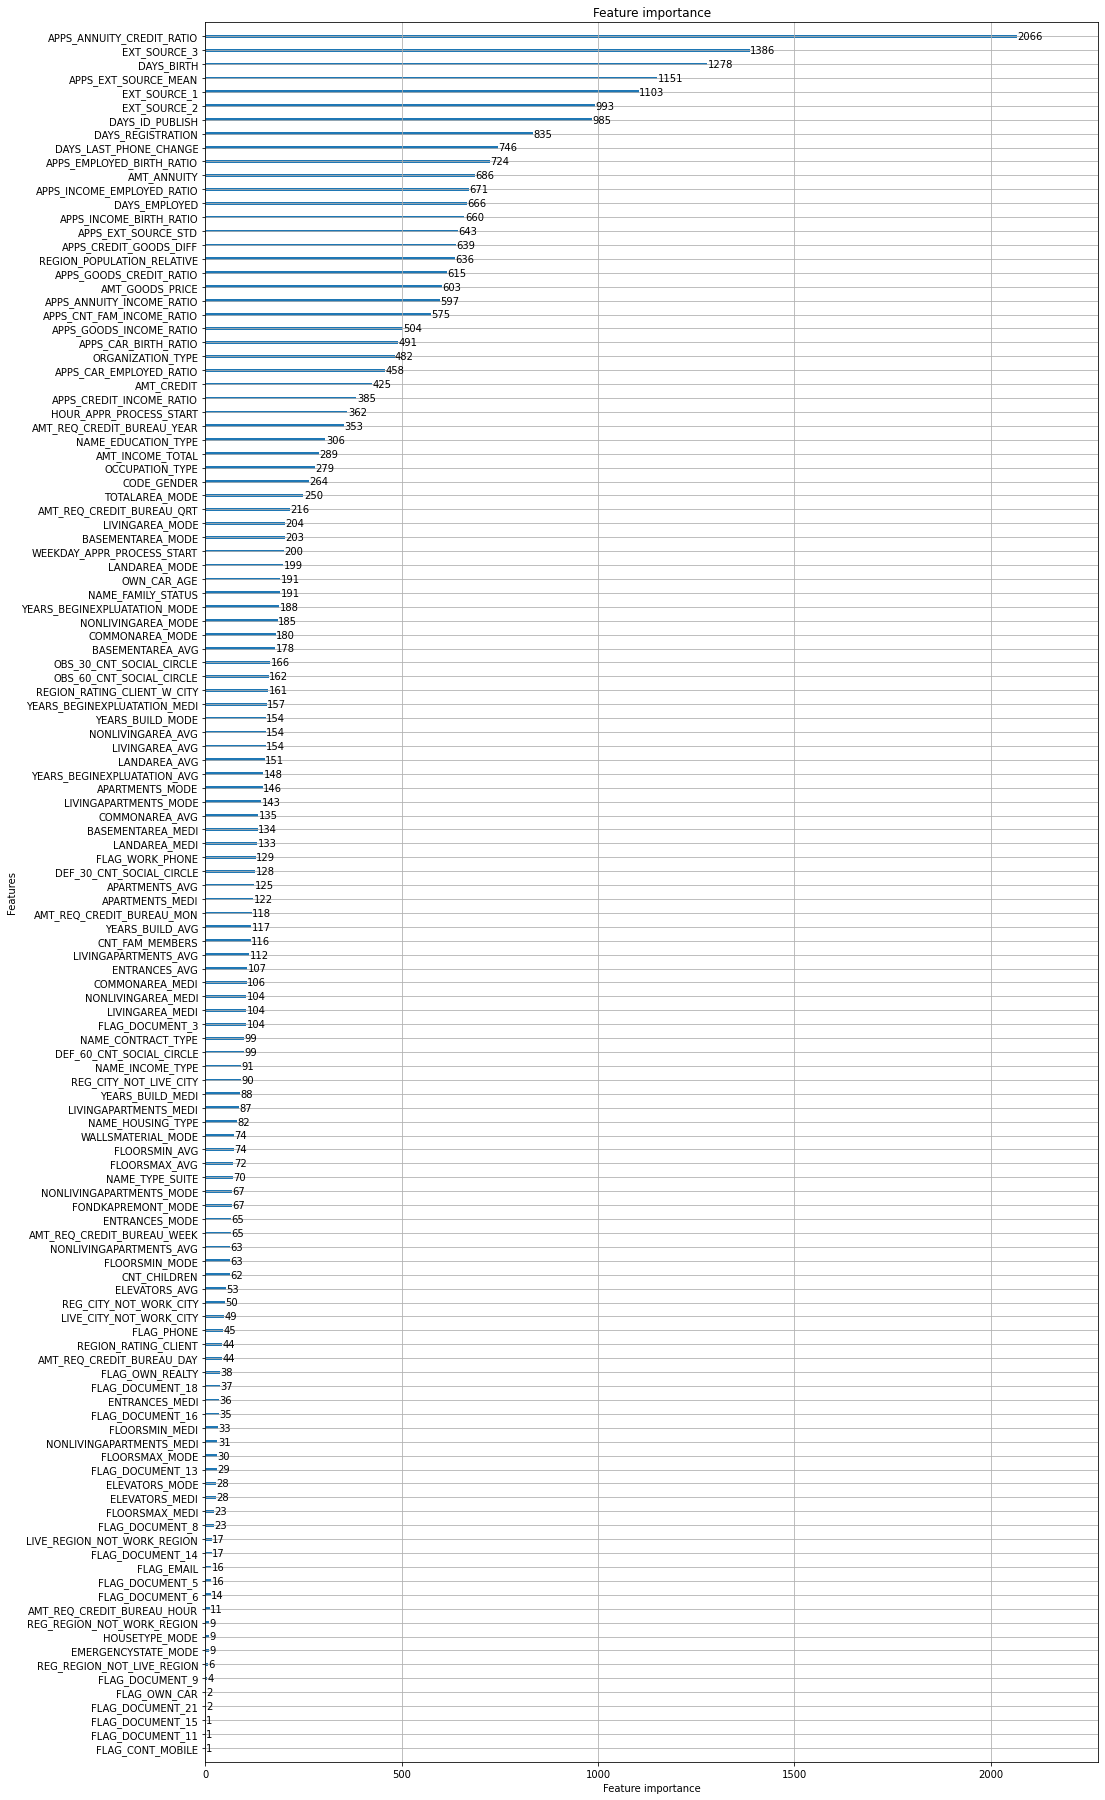

In [79]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32))

#### 학습된 Classifier를 이용하여 테스트 데이터 예측하고 결과를 Kaggle로 Submit

In [92]:
preds = clf.predict_proba(apps_test.drop(['SK_ID_CURR', 'TARGET'], axis=1))[:, 1]

In [93]:
app_test['TARGET'] = preds
app_test[['SK_ID_CURR', 'TARGET']].to_csv('../output/apps_baseline_02.csv', index=False)